# StaMPS Notebooks

## 03 Data processing pipeline monitoring

This notebook monitors the progress of the interferogram data processing pipeline and once completed, discover the result references.

In [8]:
import pandas as pd
import cioppy
import time
import os
import sys
sys.path.append(os.getcwd())
from enb_stamps_helpers import *
from shapely.geometry import box
from shapely.wkt import loads
import gdal
import osr
from urlparse import urlparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

gdal.UseExceptions()

%store -r
%matplotlib inline

In [9]:
stack_name 

'strasbourg_enb'

In [44]:
data_items = pd.read_pickle('data_items.pkl')

In [50]:
def check_status(row, creds):

    ciop = cioppy.Cioppy()

    search = ciop.search(end_point=row.self,
                params=[],
                output_fields='self,cat,link:results',
                model='GeoTime',
                creds=creds)[0]

    series = dict()

    series['status'] = filter(lambda element: 'source' in element, search['cat'].split(';'))[0]
    series['link_results'] = search['link:results']

    return pd.Series(series)

Add the columns for storing the status and link to the results:

In [ ]:
creds = ':'.join([username, api_key])


In [51]:
data_items.update(data_items.apply(lambda row: check_status(row, creds), axis=1))

Exception: ('subprocess returned: 124\n2019-10-18 17:04:25,625 [1] ERROR Terradue.OpenSearch.Client.OpenSearchClient - OpenSearchClient : Timed out \n', u'occurred at index 13')

In [49]:
data_items

cat link:results  \
0   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
1   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
2   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
3   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
4   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
5   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
6   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
7   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
8   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
9   dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
10  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
11  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
12  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
13  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
14  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
15  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
16  dataitem;track_15;strasbourg_enb;swath_IW1;mas...                
17  dataitem;first_run;track_15;stamps_stack_fbrit...                

                                                 self        status  
0   https://catalog.terradue.com/fbrito/search?for...  source-queue  
1   https://catalog.terradue.com/fbrito/search?for...  source-queue  
2   https://catalog.terradue.com/fbrito/search?for...  source-queue  
3   https://catalog.terradue.com/fbrito/search?for...  source-queue  
4   https://catalog.terradue.com/fbrito/search?for...  source-queue  
5   https://catalog.terradue.com/fbrito/search?for...  source-queue  
6   https://catalog.terradue.com/fbrito/search?for...  source-queue  
7   https://catalog.terradue.com/fbrito/search?for...  source-queue  
8   https://catalog.terradue.com/fbrito/search?for...  source-queue  
9   https://catalog.terradue.com/fbrito/search?for...  source-queue  
10  https://catalog.terradue.com/fbrito/search?for...  source-queue  
11  https://catalog.terradue.com/fbrito/search?for...  source-queue  
12  https://catalog.terradue.com/fbrito/search?for...  source-queue  
13  https://catalog.terradue.com/fbrito/search?for...  source-queue  
14  https://catalog.terradue.com/fbrito/search?for...  source-queue  
15  https://catalog.terradue.com/fbrito/search?for...  source-queue  
16  https://catalog.terradue.com/fbrito/search?for...  source-queue  
17  https://catalog.terradue.com/fbrito/search?for...  source-queue

Monitor the status of each of the data items:

In [40]:

while not ((len(data_items['status'].unique()) == 1) and (str(data_items['status'].unique()[0]) == 'source-out')):
    
    data_items.update(data_items.apply(lambda row: check_status(row), axis=1))
    
    print data_items['status'].unique()
   
    time.sleep(120)

['source-queue']
['source-queue']


KeyboardInterrupt: 

If the status is *source-out*, the data items have now a link pointing to the results:

In [41]:
ciop = cioppy.Cioppy()

end_point = 'https://catalog.terradue.com/{}/search'.format(username)

creds = ':'.join([username, api_key])

data_items = gpd.GeoDataFrame(ciop.search(end_point=end_point,
                                  params=search_params,
                                  output_fields='self,link:results',
                                  model='EOP', 
                                  timeout=50000,
                                  creds=creds))

In [42]:
data_items

link:results                                               self
0                https://catalog.terradue.com/fbrito/search?for...
1                https://catalog.terradue.com/fbrito/search?for...
2                https://catalog.terradue.com/fbrito/search?for...
3                https://catalog.terradue.com/fbrito/search?for...
4                https://catalog.terradue.com/fbrito/search?for...
5                https://catalog.terradue.com/fbrito/search?for...
6                https://catalog.terradue.com/fbrito/search?for...
7                https://catalog.terradue.com/fbrito/search?for...
8                https://catalog.terradue.com/fbrito/search?for...
9                https://catalog.terradue.com/fbrito/search?for...
10               https://catalog.terradue.com/fbrito/search?for...
11               https://catalog.terradue.com/fbrito/search?for...
12               https://catalog.terradue.com/fbrito/search?for...
13               https://catalog.terradue.com/fbrito/search?for...
14               https://catalog.terradue.com/fbrito/search?for...
15               https://catalog.terradue.com/fbrito/search?for...
16               https://catalog.terradue.com/fbrito/search?for...
17               https://catalog.terradue.com/fbrito/search?for...

For each data item, use the link:results to discover what has been produced.

Aggregate all results in a single Pandas data frame:

In [133]:
results = pd.DataFrame()

for index, row in data_items.iterrows():
    
    tmp_results = pd.DataFrame.from_dict(cioppy.Cioppy().search(end_point=row.link_results, 
                                                                params=[],
                                                                output_fields='self,identifier,enclosure,title,link:results',
                                                                model='GeoTime',
                                                                creds=creds))
    
    if index == 0:
        results = tmp_results
    else:
        results = pd.concat([results, tmp_results])
    

In [134]:
results

enclosure  \
0  https://store.terradue.com/fbrito/_results/wor...   
1  https://store.terradue.com/fbrito/_results/wor...   
2  https://store.terradue.com/fbrito/_results/wor...   
3  https://store.terradue.com/fbrito/_results/wor...   
4  https://store.terradue.com/fbrito/_results/wor...   
0  https://store.terradue.com/fbrito/_results/wor...   
1  https://store.terradue.com/fbrito/_results/wor...   
2  https://store.terradue.com/fbrito/_results/wor...   
3  https://store.terradue.com/fbrito/_results/wor...   
4  https://store.terradue.com/fbrito/_results/wor...   
0  https://store.terradue.com/fbrito/_results/wor...   
1  https://store.terradue.com/fbrito/_results/wor...   
2  https://store.terradue.com/fbrito/_results/wor...   
3  https://store.terradue.com/fbrito/_results/wor...   
4  https://store.terradue.com/fbrito/_results/wor...   

                                 identifier  \
0  07ED92B9CC6A1010FF8F2E6E74B6DDEDD0C1D96E   
1  28CF1B5225474D292740E6BB7D20290FA180694B   
2  40CBE8E5A13005C53D1607E1E029251FB3B1CC74   
3  853AA091665EF26D0E4D13F34B80C60FA4984F05   
4  B2FFF275D9176A5A5E74C0AE75DD944947CDCC84   
0  15EE114EDCBDC25360A46AECA153054366BCE909   
1  29215D5F38A9C7322BED5FFF2819E5A7375072BA   
2  A9D6D111F83BE62CEE155FDAE563859D5C7A7837   
3  E1CD5DF77803BCD7B10F1F527C3C8343CD36573E   
4  EDB65558855DA6E236DD90EB8D6C61D5E221B77B   
0  1319AFCFC2213C0E48D171987268572A4582B830   
1  325BBC25F00327B72DADA9955626AF973879D6E5   
2  4277582900D089D32C04323D51B5F06034C5D09E   
3  64B8A09C48EA76E80C0537502FDAD001C30BB215   
4  EA3EAB4D5A8E04FBD5FF442567A712B76DA02C5F   

                                        link:results  \
0  https://catalog.terradue.com/fbrito/search?uid...   
1  https://catalog.terradue.com/fbrito/search?uid...   
2  https://catalog.terradue.com/fbrito/search?uid...   
3  https://catalog.terradue.com/fbrito/search?uid...   
4  https://catalog.terradue.com/fbrito/search?uid...   
0  https://catalog.terradue.com/fbrito/search?uid...   
1  https://catalog.terradue.com/fbrito/search?uid...   
2  https://catalog.terradue.com/fbrito/search?uid...   
3  https://catalog.terradue.com/fbrito/search?uid...   
4  https://catalog.terradue.com/fbrito/search?uid...   
0  https://catalog.terradue.com/fbrito/search?uid...   
1  https://catalog.terradue.com/fbrito/search?uid...   
2  https://catalog.terradue.com/fbrito/search?uid...   
3  https://catalog.terradue.com/fbrito/search?uid...   
4  https://catalog.terradue.com/fbrito/search?uid...   

                                                self  \
0  https://catalog.terradue.com//fbrito/cat/e8504...   
1  https://catalog.terradue.com//fbrito/cat/e8504...   
2  https://catalog.terradue.com//fbrito/cat/e8504...   
3  https://catalog.terradue.com//fbrito/cat/e8504...   
4  https://catalog.terradue.com//fbrito/cat/e8504...   
0  https://catalog.terradue.com//fbrito/cat/5f06b...   
1  https://catalog.terradue.com//fbrito/cat/5f06b...   
2  https://catalog.terradue.com//fbrito/cat/5f06b...   
3  https://catalog.terradue.com//fbrito/cat/5f06b...   
4  https://catalog.terradue.com//fbrito/cat/5f06b...   
0  https://catalog.terradue.com//fbrito/cat/01835...   
1  https://catalog.terradue.com//fbrito/cat/01835...   
2  https://catalog.terradue.com//fbrito/cat/01835...   
3  https://catalog.terradue.com//fbrito/cat/01835...   
4  https://catalog.terradue.com//fbrito/cat/01835...   

                                               title  
0  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Unwr...  
1  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte...  
2  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte...  
3  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte...  
4                                           logs.zip  
0  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte...  
1  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte...  
2  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Unwr...  
3                                           logs.zip  
4  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Inte

Now plot the unwrapped phase around the event:

In [135]:
eq_id = 'ci38457511'

search_eq = EarthQuakes()

search_eq.search_id('ci38457511')

search_eq.earthquakes[0].pgv_aoi.wkt

'POLYGON ((-116.8605389899152 35.0580755365578, -116.8605389899152 36.10477822072549, -117.9175550338945 36.10477822072549, -117.9175550338945 35.0580755365578, -116.8605389899152 35.0580755365578))'

In [140]:
list(search_eq.earthquakes[0].pgv_aoi.bounds)

[-117.91755503389453, 35.0580755365578, -116.86053898991524, 36.10477822072549]

In [142]:
def get_vsi_url(enclosure, username, api_key):
    
    
    parsed_url = urlparse(enclosure)

    url = '/vsicurl/%s://%s:%s@%s/api%s' % (list(parsed_url)[0],
                                            user, 
                                            api_key, 
                                            list(parsed_url)[1],
                                            list(parsed_url)[2])
    
    return url 



In [164]:
def vsi_download(row, bbox, username, api_key):
    
    vsi_url = get_vsi_url(row.enclosure, username, api_key)
    
    ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1] 
    
    # load VSI URL in memory
    output = '/vsimem/subset.tif'
    
    ds = gdal.Open(vsi_url)
    
    ds = gdal.Translate(destName=output, 
                        srcDS=ds, 
                        projWin = [ulx, uly, lrx, lry], 
                        projWinSRS = 'EPSG:4326',
                        outputType=gdal.GDT_Float32)
    ds = None
    
    # create a numpy array
    ds = gdal.Open(output)
    
    layers = []

    for i in range(1, ds.RasterCount+1):
        layers.append(ds.GetRasterBand(i).ReadAsArray())

    return np.dstack(layers)



In [196]:
results[results.title.str.contains('Unwrap')]

enclosure  \
0  https://store.terradue.com/fbrito/_results/wor...   
2  https://store.terradue.com/fbrito/_results/wor...   
3  https://store.terradue.com/fbrito/_results/wor...   

                                 identifier  \
0  07ED92B9CC6A1010FF8F2E6E74B6DDEDD0C1D96E   
2  A9D6D111F83BE62CEE155FDAE563859D5C7A7837   
3  64B8A09C48EA76E80C0537502FDAD001C30BB215   

                                        link:results  \
0  https://catalog.terradue.com/fbrito/search?uid...   
2  https://catalog.terradue.com/fbrito/search?uid...   
3  https://catalog.terradue.com/fbrito/search?uid...   

                                                self  \
0  https://catalog.terradue.com//fbrito/cat/e8504...   
2  https://catalog.terradue.com//fbrito/cat/5f06b...   
3  https://catalog.terradue.com//fbrito/cat/01835...   

                                               title  
0  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Unwr...  
2  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Unwr...  
3  DIAPASON InSAR Sentinel-1 TOPSAR(IW,EW) - Unwr...

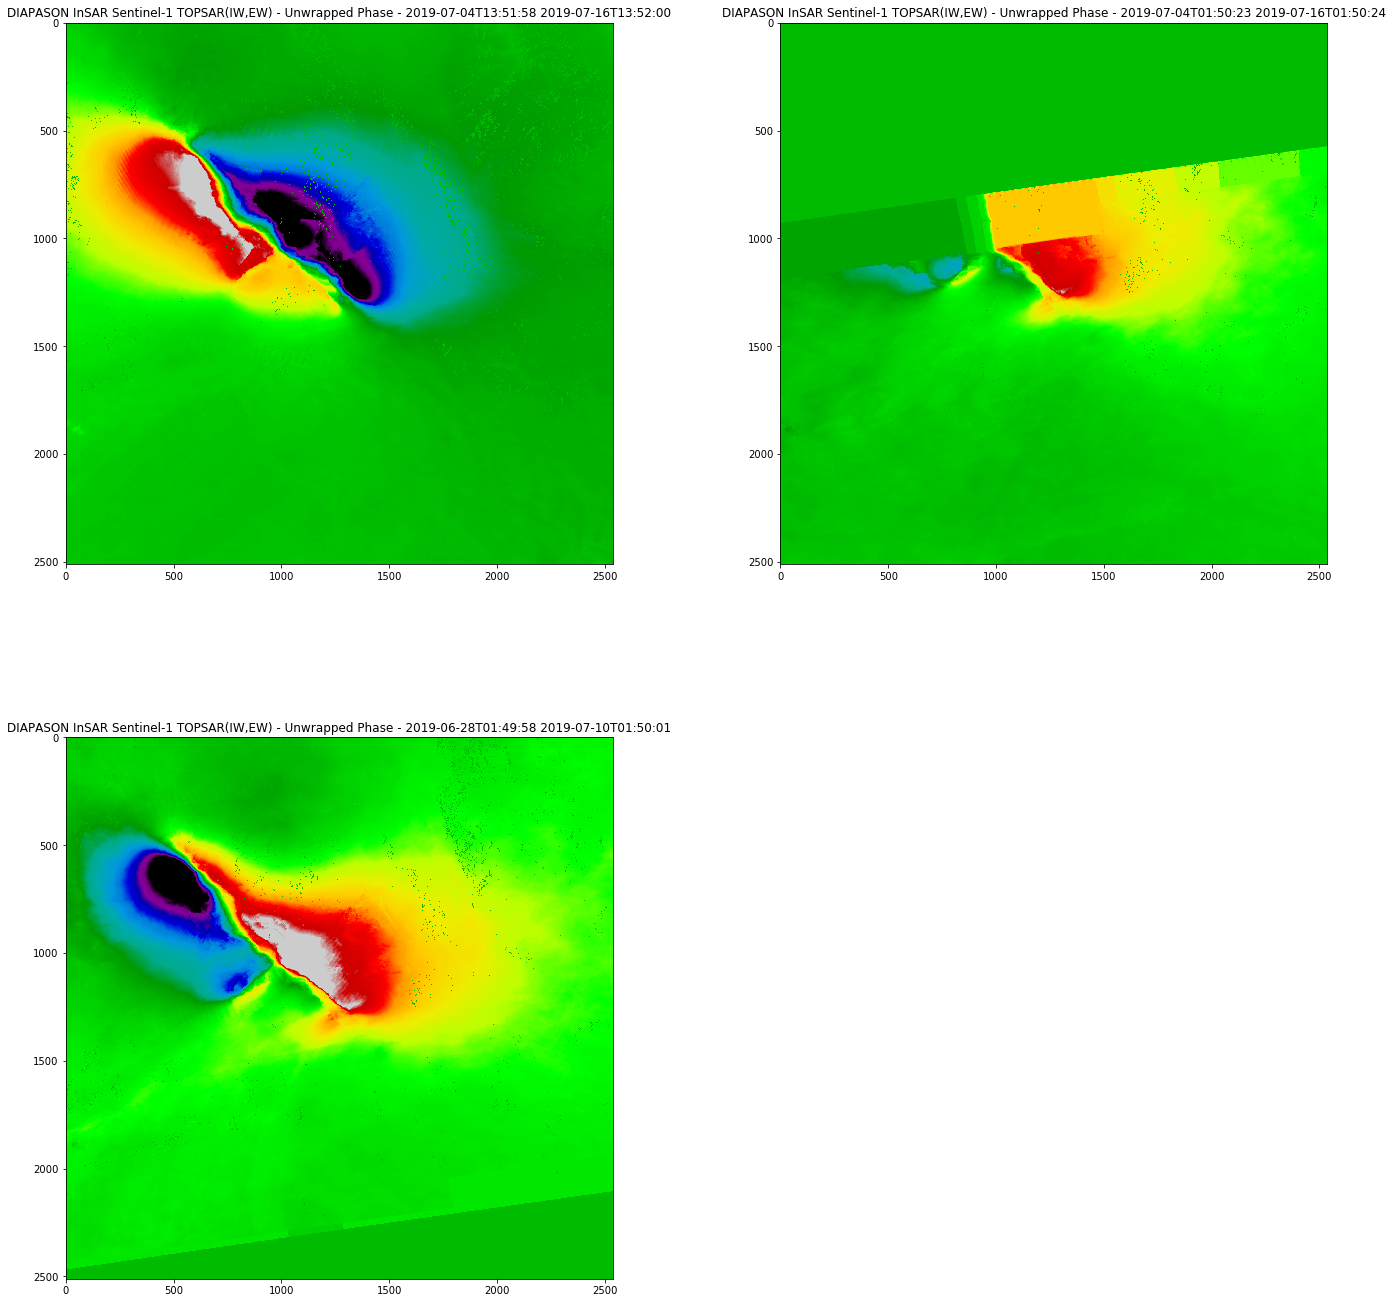

In [197]:
fig = plt.figure(figsize=(20,20))

i=1
for index, row in results[results.title.str.contains('Unwrap')].iterrows():
   
    img = vsi_download(row, 
                       list(search_eq.earthquakes[0].pgv_aoi.bounds), 
                       username, 
                       api_key)


    
    a=fig.add_subplot(2, 2, 0+i)
    imgplot = plt.imshow(img.reshape(img.shape[0],img.shape[1]),
                     cmap=plt.cm.spectral, 
                     vmin=-100,
                     vmax=100)
    a.set_title(row.title)
    i = i+1
        
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.